In [1]:
import numpy as np
from scipy import special, optimize
from math import factorial as fact
import matplotlib.pyplot as plt
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rcParams['font.size'] = 15
plt.rcParams["axes.labelsize"] = 15

# image

In [9]:
def para(a,b,theta):
    alpha = np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2)
    beta  = np.sqrt(b**2*np.cos(theta)**2 + a**2*np.sin(theta)**2)
    gamma = np.sin(2*theta)*(a**2-b**2)/(2*alpha*beta)
    return alpha,beta,gamma


def k(alpha, beta, gamma):
    """normalizing constant for PSF"""
    K = beta*alpha*np.sqrt(1 - gamma*gamma) / (2*np.pi)
    return K


def integrate_lim(x,y,thetaX,thetaY,alpha,beta,a):
    """integration limits for mu_prime"""
    u1 = alpha * (x-thetaX-a/2)
    u2 = alpha * (x-thetaX+a/2)
    v1 = beta  * (y-thetaY-a/2)
    v2 = beta  * (y-thetaY+a/2)
    return u1,u2,v1,v2
   
    
def numIntegrand_muP(x,y1,y2,gamma):
    """integrand of mu_prime, integrate over x, constants y1 & y2"""
    deltaErf = special.erf((y2+x*gamma)/np.sqrt(2))-special.erf((y1+x*gamma)/np.sqrt(2)) 
    integrand = np.sqrt(np.pi/2) * np.exp(x*x*(gamma*gamma-1)/2)*deltaErf
    return integrand


def numIntegrate(x1,x2,y1,y2,gamma,numSteps,integrand):
    """numerical integration of mu_prime, integration over x"""
    x = np.linspace(x1,x2,numSteps)
    h = (x2-x1)/(numSteps-1)
    trapzSum = 0
    for i in range(len(x)):
        trapzSum += integrand(x[i],y1,y2,gamma) * h
    trapzSum = trapzSum - h/2 * (integrand(x[0],y1,y2,gamma)+integrand(x[-1],y1,y2,gamma))
    return trapzSum


def mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps):
    """integrate analytically and numerically"""
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    mu_p = np.zeros(x.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            maxVal = max([abs(val) for val in [u1[i,j],u2[i,j],v1[i,j],v2[i,j]]])
            if maxVal == abs(u1[i,j]) or maxVal == abs(u2[i,j]):
                #integrate numerically over u
                mu_p[i,j] = numIntegrate(u1[i,j],u2[i,j],v1[i,j],v2[i,j],gamma,numSteps,numIntegrand_muP)
            elif maxVal == abs(v1[i,j]) or maxVal == abs(v2[i,j]):
                mu_p[i,j] = numIntegrate(v1[i,j],v2[i,j],u1[i,j],u2[i,j],gamma,numSteps,numIntegrand_muP)
    return mu_p



def mu(x,y,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg):
    """image model for gaussian psf"""
    K1 = k(alpha1, beta1, gamma1)
    K2 = k(alpha2, beta2, gamma2)
    mu_p1 = mu_prime(x,y,X1,Y1,alpha1,beta1,gamma1,a,numSteps)
    mu_p2 = mu_prime(x,y,X2,Y2,alpha2,beta2,gamma2,a,numSteps)
    mu = I1*K1*mu_p1/alpha1/beta1 + I2*K2*mu_p2/alpha2/beta2 + thetabg*a**2
    return mu


# test image

photon count sim: 19.9990
photon count true: 20.0002
alpha1=0.42, beta1=0.42, gamma1=-0.38, theta1=0.25Pi
alpha2=0.85, beta2=0.85, gamma2=0.38, theta2=0.75Pi
X1=9.50, Y1=9.50, X2=14.50, Y2=14.50
xmax=24, a=0.2, bg=1e-05,


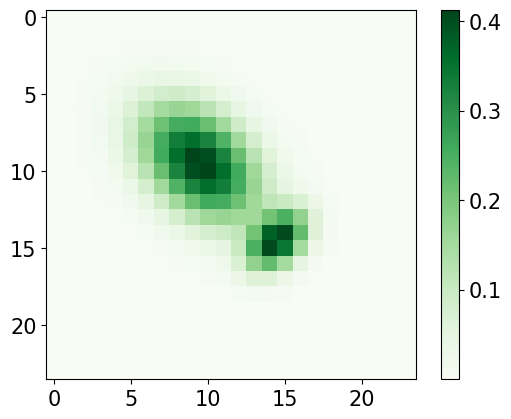

In [34]:
theta1, theta2 = np.pi/4, np.pi/4*3
width1 = 3
height1 = 2
width2 = 1.5
height2 = 1
alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)
alpha2,beta2,gamma2 = para(1/width2,1/height2,theta2)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X-2
Y1 = Y-2
X2 = X+3
Y2 = Y+3
a = 0.2
thetabg = 1e-5
numSteps = 30
I1 = 400
I2 = 100

x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
plt.imshow(m,cmap="Greens")
plt.colorbar();

print(f'photon count sim: {np.sum(m):.4f}')
print(f'photon count true: {a**2*thetabg*xmax**2+I1*a**2+I2*a**2:.4f}')
print(f"alpha1={alpha1:.2f}, beta1={beta1:.2f}, gamma1={gamma1:.2f}, theta1={theta1/np.pi}Pi")
print(f"alpha2={alpha2:.2f}, beta2={beta2:.2f}, gamma2={gamma2:.2f}, theta2={theta2/np.pi}Pi")
print(f"X1={X1:.2f}, Y1={Y1:.2f}, X2={X2:.2f}, Y2={Y2:.2f}")
print(f"xmax={xmax}, a={a}, bg={thetabg},")

# test counts

# bounds

In [ ]:


def dmu_dthetaI0(x,y,thetaX,thetaY,a,numSteps,alpha, beta, gamma):
    """derivative of mu wrt thetaI0"""
    K = k(alpha, beta, gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,a,gamma,numSteps)
    dmu_dthetaI0 = K/alpha/beta * mu_p
    return dmu_dthetaI0


def dmu_dthetabg(a):
    """derivative of mu wrt thetabg"""
    d = a**2
    return d


def dErf(x,y1,y2):
    """delta error functions for thetaX, thetaY derivatives"""
    deltaErf = special.erf((y1+x*gamma)/np.sqrt(2))-special.erf((y2+x*gamma)/np.sqrt(2)) 
    return deltaErf


def dmu_dthetaX(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0):
    """derivative of mu wrt thetaX"""
    K = k(alpha, beta, gamma)/alpha/beta
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,a)
    derf_u1 = dErf(u1,v2,v1)
    derf_u2 = dErf(u2,v2,v1)
    bracket = np.exp(u2*u2*(gamma*gamma-1)/2)*derf_u2 - np.exp(u1*u1*(gamma*gamma-1)/2)*derf_u1
    dmu_dthetaX = thetaI0*K*(-alpha)*np.sqrt(np.pi/2)*bracket
    return dmu_dthetaX


def dmu_dthetaY(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0):
    """derivative of mu wrt thetaY"""
    K = k(alpha, beta, gamma)/alpha/beta
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,a)
    derf_v1 = dErf(v1,u2,u1)
    derf_v2 = dErf(v2,u2,u1)
    bracket = np.exp(v2*v2*(gamma*gamma-1)/2)*derf_v2 - np.exp(v1*v1*(gamma*gamma-1)/2)*derf_v1
    dmu_dthetaY = thetaI0*K*(-beta)*np.sqrt(np.pi/2)*bracket
    return dmu_dthetaY


def dK(alpha, beta, gamma, dAlpha=False, dBeta=False, dGamma=False):
    """derivatives of K wrt alpha, beta, gamma"""
    if dAlpha:
        dK = beta*np.sqrt(1-gamma*gamma)/(2*np.pi)
    elif dBeta: 
        dK = alpha*np.sqrt(1-gamma*gamma)/(2*np.pi)
    elif dGamma:
        dK = -alpha*beta*gamma/(2*np.pi*np.sqrt(1-gamma*gamma))
    return dK


def dmu_dalpha(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0, numSteps):
    """derivative of image model wrt alpha"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,a)
    derf_u1 = dErf(u1,v2,v1)
    derf_u2 = dErf(u2,v2,v1)
    mu_p = mu_prime(x,y,thetaX,thetaY,a,gamma,numSteps)
    bracket = np.exp(u2*u2*(gamma*gamma-1)/2)*derf_u2*(x-thetaX+a/2)- np.exp(u1*u1*(gamma*gamma-1)/2)*derf_u1*(x-thetaX-a/2) 
    dK_dalpha = dK(alpha, beta, gamma, dAlpha=True)
    dmuP_dalpha = np.sqrt(np.pi/2)*bracket
    dmu_dalpha = -thetaI0/beta * (dK_dalpha*mu_p/alpha - K*mu_p/alpha**2 + K/alpha*dmuP_dalpha)
    return dmu_dalpha


def dmu_dbeta(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of image model wrt beta"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,a)
    derf_v1 = dErf(v1,u2,u1)
    derf_v2 = dErf(v2,u2,u1)
    mu_p = mu_prime(x,y,thetaX,thetaY,a,gamma,numSteps)
    bracket = np.exp(v2*v2*(gamma*gamma-1)/2)*derf_v2*(y-thetaY+a/2) - np.exp(v1*v1*(gamma*gamma-1)/2)*derf_v1*(y-thetaY-a/2)
    dK_dbeta = dK(alpha, beta, gamma, dBeta=True)
    dmuP_dbeta = np.sqrt(np.pi/2)*bracket
    dmu_dbeta = -thetaI0/alpha * (dK_dbeta*mu_p/beta - K*mu_p/beta**2 + K/beta*dmuP_dbeta)
    return dmu_dbeta


def dmuPrime_dGamma_integrand(x,y1,y2,gamma):
    """derivative of mu_prime wrt gamma integrand"""
    #integrate over x
    brac1 = 2+np.exp((y1+x*gamma)**2/2)*np.sqrt(2*np.pi)*x*gamma*special.erf((y1+x*gamma)/np.sqrt(2))
    brac2 = 2+np.exp((y2+x*gamma)**2/2)*np.sqrt(2*np.pi)*x*gamma*special.erf((y2+x*gamma)/np.sqrt(2))
    p1 = np.exp(-y1**2/2-0.5*x*(x+2*y1*gamma))*brac1
    p2 = np.exp(-y2**2/2-0.5*x*(x+2*y2*gamma))*brac2
    integrand = 0.5*x*(p2-p1)
    return integrand


def dmuPrime_dGamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of mu_prime wrt gamma"""
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,a)
    dmuPrime_dGamma = np.zeros(x.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            maxVal = max([abs(i) for i in [u1[i,j],u2[i,j],v1[i,j],v2[i,j]]])
            if maxVal == abs(u1[i,j]) or maxVal == abs(u2[i,j]):
                #integrate numerically over u
                dmuPrime_dGamma[i,j] = numIntegrate(u1[i,j],u2[i,j],v1[i,j],v2[i,j],gamma,numSteps,dmuPrime_dGamma_integrand)
            elif maxVal == abs(v1[i,j]) or maxVal == abs(v2[i,j]):
                dmuPrime_dGamma[i,j] =  numIntegrate(v1[i,j],v2[i,j],u1[i,j],u2[i,j],gamma,numSteps,dmuPrime_dGamma_integrand)
    return dmuPrime_dGamma


def dmu_dgamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of image model wrt gamma"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,a)
    dK_dgamma = dK(alpha, beta, gamma, dGamma=True)
    mu_p = mu_prime(x,y,thetaX,thetaY,a,gamma,numSteps)
    dmuP_dgamma = dmuPrime_dGamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps)
    dmu_dgamma = thetaI0/alpha/beta * (K*dmuP_dgamma + dK_dgamma*mu_p)
    return dmu_dgamma


def takeDer(para,x,y,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps):
    """take derivatives options"""
    if para == "X1":
        der = dmu_dthetaX(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1)
    elif para == "Y1":
        der = dmu_dthetaY(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1)
    elif para == "I1":
        der = dmu_dthetaI0(x,y,X1,Y1,a,numSteps,alpha1, beta1, gamma1)
    elif para == "alpha1":
        der = dmu_dalpha(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1, numSteps)
    elif para == "beta1":
        der = dmu_dbeta(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1,numSteps)
    elif para == "gamma1":
        der = dmu_dgamma(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1,numSteps)
        
    elif para == "X12":
        der = dmu_dthetaX(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2)
    elif para == "Y2":
        der = dmu_dthetaY(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2)
    elif para == "I2":
        der = dmu_dthetaI0(x,y,X2,Y2,a,numSteps,alpha2, beta2, gamma2)
    elif para == "alpha2":
        der = dmu_dalpha(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2, numSteps)
    elif para == "beta2":
        der = dmu_dbeta(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2,numSteps)
    elif para == "gamma2":
        der = dmu_dgamma(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2,numSteps)
        
    elif para == "thetabg":
        der = dmu_dthetabg(a)
    return der


def fisher(xmax, ymax, thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps,thetabg):
    """calculate fisher matrix"""
    para = ["X1", "Y1", "I1", "alpha1", "beta1","gamma1",
            "X2", "Y2", "I2", "alpha2", "beta2","gamma2","thetabg"]
    n = len(para)
    fisher = np.zeros((n,n))
    
    x, y = np.arange(xmax), np.arange(ymax)
    xs, ys = np.meshgrid(x,y)
    ys = np.flipud(ys)
    mus= mu(xs,ys,X1,Y1,I1,a,numSteps,alpha1,beta1,gamma1,thetabg) + \
            mu(xs,ys,X2,Y2,I2,a,numSteps,alpha2,beta2,gamma2,thetabg) - thetabg*a**2

    for i in range(n):
        for j in range(n):
            fisher[i,j] = np.sum(1/mus * takeDer(para[i],xs,ys,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps) * \
                                 takeDer(para[j],xs,ys,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps))
    return fisher


def crlb(xmax, ymax, thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps,thetabg):
    """inverse fisher, retrieve CRLBs"""
    fisherM = fisher(xmax, ymax, thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps,thetabg)
    fisherInv = np.linalg.inv(fisherM)
    crlbs = [fisherInv[i,i] for i in range(len(fisherM))]
    print("#",end="")
    return crlbs


